In [7]:
s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"
data_dir = "temp"

In [8]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/model_Cnn_190424_2251 $data_dir --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

download: s3://aegovan-data/results/model_Cnn_190424_2251/feature_lens.json to temp/feature_lens.json
download: s3://aegovan-data/results/model_Cnn_190424_2251/classes.json to temp/classes.json
download: s3://aegovan-data/results/model_Cnn_190424_2251/training_scores_epoch_Objectdump_20190425_000043_c00447da-834c-417d-b28f-2f44862c3295.json to temp/training_scores_epoch_Objectdump_20190425_000043_c00447da-834c-417d-b28f-2f44862c3295.json
download: s3://aegovan-data/results/model_Cnn_190424_2251/validation_scores_epoch_Objectdump_20190425_000043_f60d3010-0e3e-4a93-ae71-ef1efcccbd3f.json to temp/validation_scores_epoch_Objectdump_20190425_000043_f60d3010-0e3e-4a93-ae71-ef1efcccbd3f.json
download: s3://aegovan-data/results/model_Cnn_190424_2251/run.log to temp/run.log
download: s3://aegovan-data/results/model_Cnn_190424_2251/predicted_val_unique_pub_v6_less_negative.json to temp/predicted_val_unique_pub_v6_less_negative.json
download: s3://aegovan-data/results/model_Cnn_190424_2251/predic

In [9]:
!ls  $data_dir

classes.json
feature_lens.json
predicted_test_unique_pub_v6_less_negative.json
predicted_val_unique_pub_v6_less_negative.json
run.log
training_scores_epoch_Objectdump_20190425_000043_c00447da-834c-417d-b28f-2f44862c3295.json
validation_scores_epoch_Objectdump_20190425_000043_f60d3010-0e3e-4a93-ae71-ef1efcccbd3f.json


In [10]:
!head -1 $data_dir/run.log 

commit 5b07ca6fdc113140a1f6179f750391533613c061


In [11]:
!head -10 $data_dir/run.log | tail -8

Date:   Sun Apr 14 17:56:23 2019 -0700

    With correct normalisation..
{'network': 'Cnn', 'trainjson': '/data/train_unique_pub_v6_less_negative.json', 'valjson': '/data/val_unique_pub_v6_less_negative.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_Cnn_190424_2251', 'epochs': 200, 'interaction_type': None, 'log_level': 'INFO'}
2019-04-24 22:51:31,676 - __main__ - INFO - Running with interaction type None, network Cnn
2019-04-24 22:51:31,902 - __main__ - INFO - Training shape (3639, 4), test shape (479, 4)
2019-04-24 22:51:31,902 - __main__ - INFO - The embedding header is 5443656 200



In [12]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [13]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [14]:
import glob

results_file = "./temp/predicted_test_unique_pub_v6_less_negative.json"
validation_fit_file = glob.glob("temp/validation_scores_epoch_Objectdump*.json")[0]
train_fit_file = glob.glob("temp/training_scores_epoch_Objectdump*.json")[0]


pos_label = True

In [15]:
#download_single_file(s3_data, results_file)

In [16]:
import pandas as pd

In [17]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [18]:
df_results.columns


Index(['entityMentionsCount', 'hasTriggerWord', 'interactionId',
       'interactionType', 'isValid', 'lessThanThreshold', 'participant1Alias',
       'participant1Id', 'participant2Alias', 'participant2Id',
       'participants_count', 'pubmedId', 'pubmedTitle', 'pubmedabstract',
       'normalised_abstract', 'particpant1Exists', 'particpant2Exists',
       'bothParticpantsExist', 'noParticpantsExist', 'predicted',
       'confidence_scores', 'actual'],
      dtype='object')

## Analyse Results

In [19]:
df = df_results

In [20]:
df_results.shape

(999, 22)

In [21]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=3)

,true,false,actual,predicted,confidence_scores
339,0.788395,0.211605,False,True,"{'False': -1.5530354977, 'True': -0.2377556562}"
225,0.788395,0.211605,False,True,"{'False': -1.5530354977, 'True': -0.2377556562}"
353,0.788395,0.211605,False,True,"{'False': -1.5530354977, 'True': -0.2377556562}"


In [22]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"])  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))

The F1 score is 0.37689969604863216 and the accuracy is 0.5895895895895896


In [23]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

<Figure size 640x480 with 2 Axes>

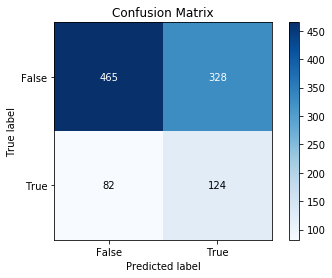

In [25]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

demethylation
deubiquitination
acetylation
ubiquitination
methylation
dephosphorylation
phosphorylation


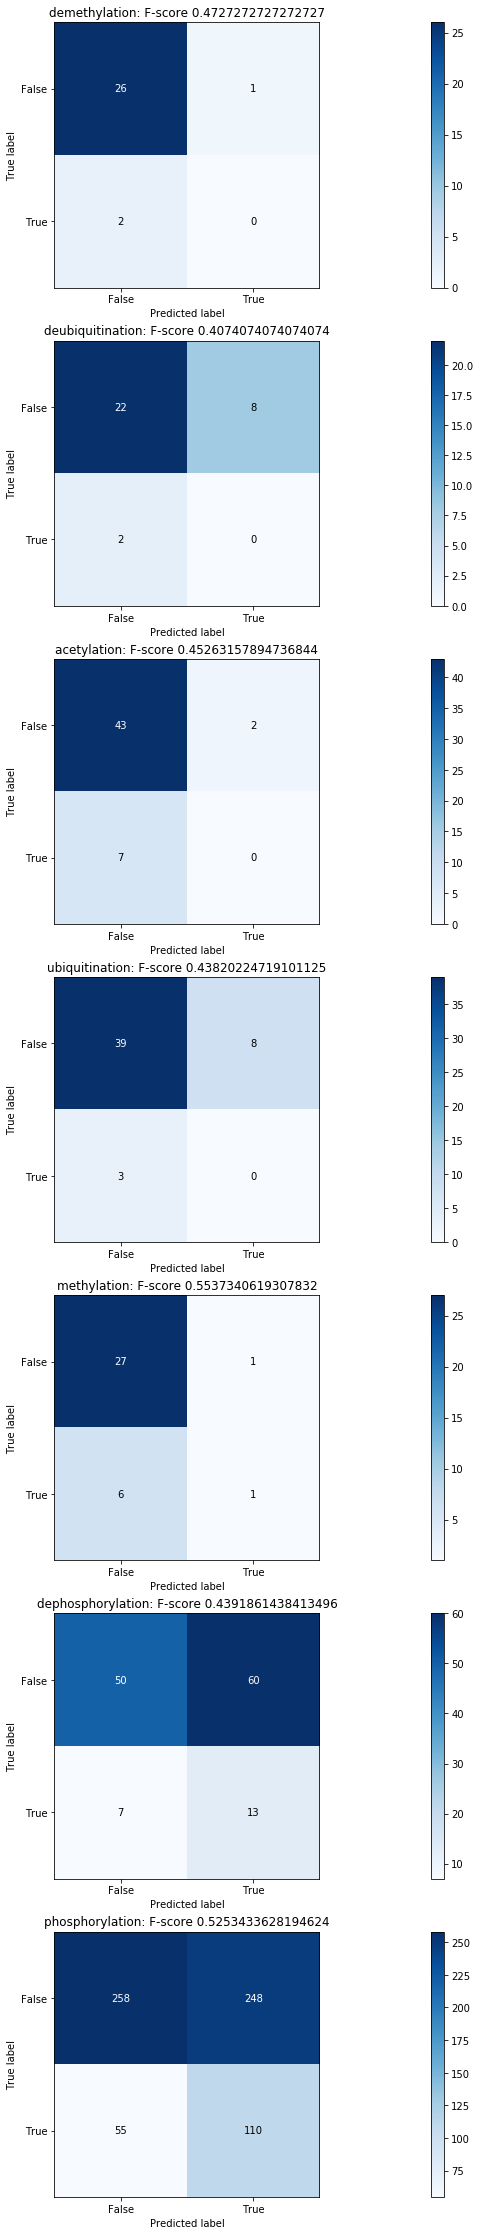

In [26]:
interactions = df["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
plt.show()
    
    


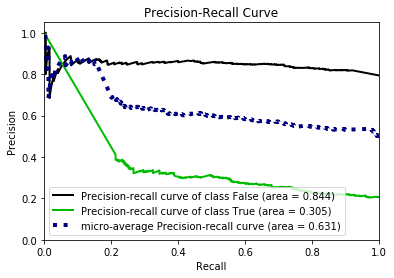

In [27]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

## Training / Validation epoch fit

In [28]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [29]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit.sort_values(["score.f-score"], ascending=False).head(n=10)

,epoch,score.accuracy,score.f-score,score.precision,score.recall
190,190,0.840890,0.598196,0.715947,0.513707
175,175,0.836768,0.583450,0.708688,0.495828
174,174,0.837043,0.583275,0.710616,0.494636
152,152,0.838967,0.582621,0.723894,0.487485
173,173,0.837318,0.582511,0.713299,0.492253
187,187,0.837593,0.582332,0.715278,0.491061
197,197,0.839791,0.582079,0.730216,0.483909
160,160,0.838417,0.581792,0.721340,0.487485
142,142,0.839242,0.581246,0.727599,0.483909
89,89,0.835669,0.581232,0.704584,0.494636


In [30]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit.sort_values(["score.f-score"], ascending=False).head(n=10)

,epoch,score.accuracy,score.f-score,score.precision,score.recall
76,76,0.574113,0.370370,0.273973,0.571429
47,47,0.572025,0.369231,0.272727,0.571429
31,31,0.546973,0.359882,0.260684,0.580952
25,25,0.572025,0.357367,0.266355,0.542857
72,72,0.526096,0.356941,0.254032,0.600000
24,24,0.630480,0.356364,0.288235,0.466667
127,127,0.528184,0.354286,0.253061,0.590476
9,9,0.615866,0.352113,0.279330,0.476190
40,40,0.538622,0.351906,0.254237,0.571429
110,110,0.467641,0.351145,0.239583,0.657143


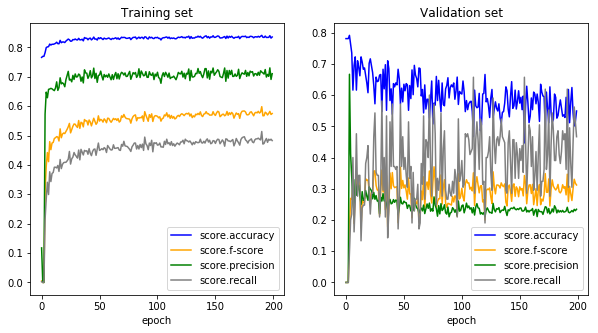

In [31]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="score.accuracy", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score.f-score", ax = ax[0], color="orange")
df_train_fit.plot.line(x="epoch", y="score.precision", ax = ax[0], color ="green")
df_train_fit.plot.line(x="epoch", y="score.recall", ax = ax[0], color ="gray")
ax[0].set_title("Training set")
ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="score.accuracy", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score.f-score", ax = ax[1], color ="orange")
df_val_fit.plot.line(x="epoch", y="score.precision", ax = ax[1], color ="green")
df_val_fit.plot.line(x="epoch", y="score.recall", ax = ax[1], color ="gray")
ax[1].set_title("Validation set")
ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

### Threshold 

In [32]:
threshold = .85
df_trues = df.query("true > {}".format(threshold))
df_trues.shape

(0, 24)

In [33]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"])  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))

The F1 score is 0.0 and the accuracy is nan


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [34]:
interactions = df_trues["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df_trues.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
plt.show()
    

<Figure size 2880x2880 with 0 Axes>